In [26]:
import cv2
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install optuna
import optuna
import time
import logging

## Imputation
from sklearn.impute import SimpleImputer, KNNImputer

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

# Machine-learning stack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
#from scipy.stats import boxcox, yeojohnson

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Evaluation Functions

In [27]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value
    
def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             pauc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Training data with labels or targets
    X_test            Testing data with features
    y_test            Testing data with labels or targets                             
    training=True     True: print scores on the training set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the cunfusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
        
    if pauc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('pAUC on trainig set: ', round(partial_auc_score(y_train, y_pred_train_p), 4))
        if test:
            print('pAUC on test set: ', round(partial_auc_score(y_test, y_pred_test_p), 4))
        print("--------"*5)
        
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')                 
        
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 n_iter=100,
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 pauc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parameters "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary including hyperparameters
    X_train               #Training data with features
    y_train               #Training data with labels or targets
    X_test                #Testing data with features
    y_test                #Testing data with labels or targets
    cv=5                  #Number of cross-validation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    n_iter=100,           #Number of iterations for RandomSearchCV (unused for full search)
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the training set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - best_params: hyperparameters of the best model
    - fig, ax: the figure objects of the confusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, n_iter=n_iter, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    predict_and_print_scores(best_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             training=training,
                             test=test,
                             accuracy=accuracy,
                             recall=recall,
                             precision=precision,
                             fbeta=fbeta,
                             roc_auc=roc_auc,
                             pauc=pauc,
                             matrix=matrix,
                             figsize=figsize,
                             cmap=cmap)
    
    return best_model, best_params

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Model Loading

In [28]:
# Read the dataset
ROOT_DATASET_DIR = "./"
file_name = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda-fe.csv")
df = pd.read_csv(file_name)

# Exploratory Data Analysis (EDA)

In [29]:
df.drop(columns=['isic_id'], inplace=True)
df['anatom_site_general'] = pd.Categorical(df['anatom_site_general'])
df['tbp_lv_location'] = pd.Categorical(df['tbp_lv_location'])
df['tbp_lv_location_simple'] = pd.Categorical(df['tbp_lv_location_simple'])

In [30]:
df.dtypes

target                               int64
age_approx                         float64
sex                                  int64
anatom_site_general               category
clin_size_long_diam_mm             float64
                                    ...   
sqrt_hue_color_std_interaction     float64
sqrt_normalized_lesion_size        float64
sqrt_color_variance_ratio          float64
sqrt_color_asymmetry_index         float64
sqrt_shape_color_consistency       float64
Length: 128, dtype: object

# Feature Preparation

In [31]:
# Original feature names
features_to_be_logtr = ['clin_size_long_diam_mm',
                        'tbp_lv_areaMM2',
                        'tbp_lv_area_perim_ratio',
                        'tbp_lv_color_std_mean',
                        'tbp_lv_deltaLB',
                        'tbp_lv_deltaLBnorm',
                        'tbp_lv_minorAxisMM',
                        'tbp_lv_norm_border',
                        'tbp_lv_norm_color',
                        'tbp_lv_perimeterMM',
                        'tbp_lv_radial_color_std_max',
                        'tbp_lv_stdL',
                        'tbp_lv_stdLExt',
                        'tbp_lv_symm_2axis']
features_to_be_sqrtr = ['tbp_lv_eccentricity']

# Modified original feature names
log_features = ['log_' + col for col in features_to_be_logtr]
sqr_features = ['sqr_' + col for col in features_to_be_sqrtr]

# New feature names
new_features_to_be_logtr = ['hue_contrast',
                            'luminance_contrast',
                            'lesion_color_difference',
                            'border_complexity',
                            #'color_uniformity',
                            'perimeter_to_area_ratio',
                            'area_to_perimeter_ratio',
                            'lesion_visibility_score',
                            'symmetry_border_consistency',
                            'consistency_symmetry_border',
                            #'color_consistency',
                            'consistency_color',
                            'size_age_interaction',
                            'lesion_severity_index',
                            'shape_complexity_index',
                            #'normalized_lesion_size',
                            'std_dev_contrast',
                            'color_shape_composite_index',
                            'symmetry_perimeter_interaction',
                            'comprehensive_lesion_index',
                            #'color_variance_ratio',
                            'border_color_interaction',
                            'size_color_contrast_ratio',
                            'age_normalized_nevi_confidence',
                            #'color_asymmetry_index',
                            'volume_approximation_3d',
                            'color_range',
                            #'shape_color_consistency',
                            'age_size_symmetry_index',
                            'index_age_size_symmetry']
new_features_to_be_sqrtr = ['lesion_shape_index',
                            'position_distance_3d']
new_features_to_be_sqrttr = ['color_consistency',
                             'hue_color_std_interaction',
                             'normalized_lesion_size',
                            #'overall_color_difference',
                             'color_variance_ratio',
                             'color_asymmetry_index',
                             'shape_color_consistency']

# Modify the column names
log_new_features = ['log_' + col for col in new_features_to_be_logtr]
sqr_new_features = ['sqr_' + col for col in new_features_to_be_sqrtr]
sqrt_new_features = ['sqrt_' + col for col in new_features_to_be_sqrttr]

# Baseline Model with Feature Engineering

In [32]:
# Train-Test split
# Drop non-used features for the baseline + target
X1 = df.drop(['target']
             + features_to_be_logtr + features_to_be_sqrtr                                         # drop original features with skeweness (no transformation)                          
             + new_features_to_be_logtr + new_features_to_be_sqrtr + new_features_to_be_sqrttr,    # drop new features with skeweness (no transformation)             
             axis=1)
y = df['target']
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
numerical_features = X1.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X1.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age_approx', 'sex', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_nevi_confidence', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm', 'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio', 'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB', 'log_tbp_lv_deltaLBnorm', 'log_tbp_lv_minorAxisMM', 'log_tbp_lv_norm_border', 'log_tbp_lv_norm_color', 'log_tbp_lv_perimeterMM', 'log_tbp_lv_radial_color_std_max', 'log_tbp_lv_stdL', 'log_tbp_lv_stdLExt', 'log_tbp_lv_symm_2axis', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'color_contrast_index', 'log_lesion_area', 'mean_hue_difference', 'lesion_orientation_3d', 'overall_color_difference', 'border_color_interaction_2', 'age_normalized_nevi_confidence_2', 'border_length_ratio', 'log_hue_contrast', 'log_luminance_contrast', 

In [34]:
# Dimensionality reduction

# Use SelectKBest for numerical features
Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
Kbest_numerical.fit(X1_train[numerical_features], y_train)

# Extract feature scores and p-values
scores = Kbest_numerical.scores_
pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_NUM = sorted_features.shape[0]
print(f"Number of relevant numerical features: {KBEST_NUM}\n")
print(sorted_features.set_index('Feature'))

# Use SelectKBest for categorical features
# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('onehot', preprocessor),
    ('kbest', SelectKBest(score_func=chi2, k='all'))
])

cat_transformed = pipeline.fit_transform(X1_train, y_train)
Kbest_categorical = pipeline.named_steps['kbest']

# Extract feature scores and p-values
scores = Kbest_categorical.scores_
pvalues = Kbest_categorical.pvalues_

# Extract feature names after one-hot encoding
one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': one_hot_feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_CAT = sorted_features.shape[0]
print(f"Number of relevant categorical features: {KBEST_CAT}\n")
print(sorted_features.set_index('Feature'))

Number of relevant numerical features: 68

                                      Score        P-Value
Feature                                                   
tbp_lv_H                         596.935096  1.030472e-131
mean_hue_difference              516.167671  3.564907e-114
tbp_lv_deltaB                    385.672387   8.152815e-86
tbp_lv_Hext                      332.404923   3.141478e-74
overall_color_difference         299.873400   3.770619e-67
...                                     ...            ...
sqrt_hue_color_std_interaction     7.667604   5.622435e-03
log_symmetry_border_consistency    5.745972   1.652708e-02
tbp_lv_L                           4.604228   3.189396e-02
tbp_lv_x                           4.396313   3.601751e-02
lesion_orientation_3d              4.292523   3.828112e-02

[68 rows x 2 columns]
Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                  

In [ ]:
# Define the objective function
def objective(trial):

    start_time = time.time()

    # Suggest values for the hyperparameters
    #penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1.0, 25.0)
    #solver = trial.suggest_categorical('solver', ['liblinear', 'saga']) #, 'lbfgs', 'newton-cholesky'])    
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   #From Kbest with a 5% threshold 68 features are obtained
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])

    preprocessing_lr = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_lr = ImbPipeline([
        ('features', preprocessing_lr),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('LR', LogisticRegression(max_iter=1000,
                                  penalty='l1',
                                  C=C,
                                  solver='liblinear',        
                                  random_state=42))
])

    print(f"Trial {trial.number}: C={C}")
    
    # Train the model
    pipe_lr.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_lr.predict_proba(X1_test)[:1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Trial {trial.number} completed in {elapsed_time:.2f} seconds. partial AUC={pauc}")

    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=50, n_jobs=1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (accuracy): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

# WITHOUT OPTUNA
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
#pAUC on trainig set:  0.1583
#pAUC on test set:  0.1481

[I 2024-08-19 18:50:08,660] A new study created in memory with name: no-name-54f0ee40-068c-4568-80ca-f2ec936ccb62


Trial 0: C=21.207477961252266


# Balanced Random Forest with Optuna

In [36]:
# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) #200-400
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 7) #2-5
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5) #1-2   
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=68)),   
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=8)),    
    ])

    preprocessing_rf = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_rf = ImbPipeline([
        ('features', preprocessing_rf),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('RF', BalancedRandomForestClassifier(random_state=42,
                                              n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              min_samples_leaf=min_samples_leaf,
                                              bootstrap=True,
                                              class_weight='balanced_subsample'
                                             )
        )
])

    # Train the model
    pipe_rf.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_rf.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=500, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

# WITHOUT OPTUNA
#    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
#    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
#Best params: {'RF__bootstrap': True, 'RF__class_weight': 'balanced_subsample', 'RF__max_depth': 20, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 300}
#pAUC on trainig set:  0.1985
#pAUC on test set:  0.1626

#OPTUNA TRIAL 1
#Best trial number: 34
#Best value (partial auc - 0.8): 0.16498926690234497
#Best hyperparameters: {'n_estimators': 398, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1}



[I 2024-08-19 15:31:13,885] A new study created in memory with name: no-name-f06b9561-ae41-48a6-974a-4a281521c1ae
[I 2024-08-19 15:32:24,200] Trial 13 finished with value: 0.16291236362459122 and parameters: {'n_estimators': 233, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.16291236362459122.
[I 2024-08-19 15:32:28,415] Trial 0 finished with value: 0.16262066120497243 and parameters: {'n_estimators': 260, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.16291236362459122.
[I 2024-08-19 15:32:34,179] Trial 1 finished with value: 0.16254198601251554 and parameters: {'n_estimators': 298, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.16291236362459122.
[I 2024-08-19 15:32:34,822] Trial 2 finished with value: 0.16252099100291717 and parameters: {'n_estimators': 303, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1

Best trial number: 34
Best value (partial auc - 0.8): 0.16498926690234497
Best hyperparameters: {'n_estimators': 398, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1}


AttributeError: 'FrozenTrial' object has no attribute 'predict'

# XGBoost

In [ ]:
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 200, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.083, 0.087)
    reg_lambda = trial.suggest_float('reg_lambda', 8.0, 9.0)
    alpha = trial.suggest_float('alpha', 0.6, 0.7)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    subsample = trial.suggest_float('subsample', 0.5, 0.7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.85, 0.95)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 0.6)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 3.2, 3.5)
    
    # Create the model with these hyperparameters
    # Pipeline
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
    ])

    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])

    preprocessing_xgb = ColumnTransformer(transformers=[
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
     ])
                               
    pipe_xgb = ImbPipeline([
        ('features', preprocessing_xgb),  
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),    
        ('XGB', XGBClassifier(random_state=42,
                             enable_categorical=True,
                             eval_metric='logloss',
                             n_estimators=n_estimators,
                             learning_rate=learning_rate, #'0.085, #0.08501257473292347,
                             reg_lambda=reg_lambda, #8.9, #8.879624125465703,
                             alpha=alpha, #0.678, #0.6779926606782505,
                             max_depth=max_depth,
                             subsample=subsample, #0.6, #0.6012681388711075,
                             colsample_bytree=colsample_bytree, #0.9, #0.8437772277074493,
                             colsample_bylevel=colsample_bylevel, #0.55, #0.5476090898823716,                             
                             scale_pos_weight=scale_pos_weight, #3.3 #3.29440313334688
                            )
        )
])

    # Train the model
    pipe_xgb.fit(X1_train, y_train)
    
    # Predict on the validation set
    preds = pipe_xgb.predict_proba(X1_test)[:,1]
    
    # Calculate accuracy
    pauc = partial_auc_score(y_test, preds)
    
    # We want to maximize accuracy, so return it as a negative value
    return pauc

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(objective, n_trials=400, n_jobs=-1)  # n_trials is the number of trials, n_jobs=-1 uses all CPUs

# Get the best trial
best_trial = study.best_trial

print(f'Best trial number: {best_trial.number}')
print(f'Best value (partial auc - 0.8): {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

#WITHOUT OPTUNA
#Best params: {'XGB__alpha': 0.678, 'XGB__colsample_bylevel': 0.55, 'XGB__colsample_bytree': 0.9,
#'XGB__enable_categorical': True, 'XGB__eval_metric': 'logloss', 'XGB__lambda': 8.9,
#'XGB__learning_rate': 0.085, 'XGB__max_depth': 20, 'XGB__n_estimators': 300,
#'XGB__random_state': 42, 'XGB__scale_pos_weight': 3.3, 'XGB__subsample': 0.6}
# pAUC on trainig set:  0.1999
# pAUC on test set:  0.1696

#OPTUNA TRIAL 1
#Best trial number: 10
#Best value (partial auc - 0.8): 0.17051976912541197
#Best hyperparameters: {'n_estimators': 308, 'max_depth': 22, 'learning_rate': 0.085, 'reg_lambda': 8.9, 'alpha': 0.678, 'subsample': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.55, 'scale_pos_weight': 3.3}

#OPTUNA TRIAL 2

[I 2024-08-19 21:02:34,326] A new study created in memory with name: no-name-5251da55-f0e7-4f6e-bffe-c8519b64889a
[I 2024-08-19 21:04:07,440] Trial 11 finished with value: 0.16633352447873873 and parameters: {'n_estimators': 293, 'learning_rate': 0.08382283137084329, 'reg_lambda': 8.151795991008777, 'alpha': 0.6611833372955856, 'max_depth': 10, 'subsample': 0.6690722476147279, 'colsample_bytree': 0.8857674333364909, 'colsample_bylevel': 0.5522304806928899, 'scale_pos_weight': 3.271314575605695}. Best is trial 11 with value: 0.16633352447873873.
[I 2024-08-19 21:04:18,522] Trial 0 finished with value: 0.16935821621269895 and parameters: {'n_estimators': 225, 'learning_rate': 0.08696593177309157, 'reg_lambda': 8.021142795707624, 'alpha': 0.699828974202612, 'max_depth': 22, 'subsample': 0.5656839426293868, 'colsample_bytree': 0.9163427172470198, 'colsample_bylevel': 0.539454321545547, 'scale_pos_weight': 3.226468479503453}. Best is trial 0 with value: 0.16935821621269895.
[I 2024-08-19 21

# LightGBM

In [113]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=kbest_num)),
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=kbest_cat)),
])

preprocessing_lgb = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])

param_lgb = {
    'LGB__objective':        ['binary'],    
    'LGB__num_iterations ':  [200],
    'LGB__n_estimators':     [400], # between 200 and 400!
    'LGB__boosting_type':    ['gbdt'],
    'LGB__lambda_l1':        [0.08758718919397321], 
    'LGB__lambda_l2':        [0.0039689175176025465], 
    'LGB__learning_rate':    [0.04], #[0.03231007103195577], 
    'LGB__max_depth':        [30], #[4], #between 20 and 30
    'LGB__num_leaves':       [31], #[103], 
    'LGB__colsample_bytree': [0.8329551585827726], 
    'LGB__colsample_bynode': [0.4025961355653304], 
    'LGB__bagging_fraction': [0.7738954452473223], 
    'LGB__bagging_freq':     [10], #[4], between 4 and 10
    'LGB__min_data_in_leaf': [2], #[85], # between 1 and 3
    'LGB__scale_pos_weight': [2.5], #[2.7984184778875543], between 2.1 to 2.8
}

pipe_lgb = ImbPipeline([    
    ('features', preprocessing_lgb),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('LGB', LGBMClassifier(random_state=42, verbosity=-1))
])

model_lgb_fe76_rsmpl, _ = train_crossval_predict_score(pipe_lgb,
                                                       param_lgb,
                                                       X1_train,
                                                       y_train,
                                                       X1_test,
                                                       y_test,
                                                       cv=5,
                                                       scoring='roc_auc',
                                                       cross_val='full',
                                                       n_iter=500, # only if randomsearchcv
                                                       random_state=42,
                                                       training=True,
                                                       test=True,
                                                       accuracy=True,
                                                       recall=True,
                                                       precision=False,
                                                       fbeta=[False, 1.0],
                                                       roc_auc=True,
                                                       pauc=True,
                                                       matrix=False)

Best params: {'LGB__bagging_fraction': 0.7738954452473223, 'LGB__bagging_freq': 10, 'LGB__boosting_type': 'gbdt', 'LGB__colsample_bynode': 0.4025961355653304, 'LGB__colsample_bytree': 0.8329551585827726, 'LGB__lambda_l1': 0.08758718919397321, 'LGB__lambda_l2': 0.0039689175176025465, 'LGB__learning_rate': 0.04, 'LGB__max_depth': 30, 'LGB__min_data_in_leaf': 2, 'LGB__n_estimators': 400, 'LGB__num_iterations ': 200, 'LGB__num_leaves': 31, 'LGB__objective': 'binary', 'LGB__scale_pos_weight': 2.5}
----------------------------------------
Accuracy on training set: 1.0
Accuracy on test set: 1.0
----------------------------------------
Recall on training set: 1.0
Recall on test set: 0.28
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.96
----------------------------------------
pAUC on trainig set:  0.1998
pAUC on test set:  0.1672
----------------------------------------


In [114]:
dump(model_lgb_fe76_rsmpl, 'model_lgb_fe76_rsmpl.pkl')
model_lgb_fe76_rsmpl = load('model_lgb_fe76_rsmpl.pkl')

In [115]:
print('pAUC on trainig set: ', round(partial_auc_score(y_train, model_lgb_fe76_rsmpl.predict_proba(X1_train)[:,1]), 4))
print('pAUC on test set: ', round(partial_auc_score(y_test, model_lgb_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print("--------"*5)

pAUC on trainig set:  0.1998
pAUC on test set:  0.1672
----------------------------------------


# Evaluate Models

In [116]:
model_lr_base = load('model_lr_baseline.pkl')
model_lr_fe76 = load('model_lr_fe76.pkl')
model_lr_fe76_rsmpl = load('model_lr_fe76_rsmpl.pkl')
model_rf_fe76_rsmpl = load('model_rf_fe76_rsmpl.pkl')
model_xgb_fe76_rsmpl = load('model_xgb_fe76_rsmpl.pkl')
model_lgb_fe76_rsmpl = load('model_lgb_fe76_rsmpl.pkl')

print('pAUC - LR - baseline: ', round(partial_auc_score(y_test, model_lr_base.predict_proba(Xb_test)[:,1]), 4))
print('pAUC - LR - fe76: ', round(partial_auc_score(y_test, model_lr_fe76.predict_proba(X1_test)[:,1]), 4))
print('pAUC - LR - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_lr_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - RF - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - XGB - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))
print('pAUC - LGB - fe76 - rsmpl: ', round(partial_auc_score(y_test, model_lgb_fe76_rsmpl.predict_proba(X1_test)[:,1]), 4))

pAUC - LR - baseline:  0.1367
pAUC - LR - fe76:  0.1463
pAUC - LR - fe76 - rsmpl:  0.1477
pAUC - RF - fe76 - rsmpl:  0.1626
pAUC - XGB - fe76 - rsmpl:  0.1696
pAUC - LGB - fe76 - rsmpl:  0.1672


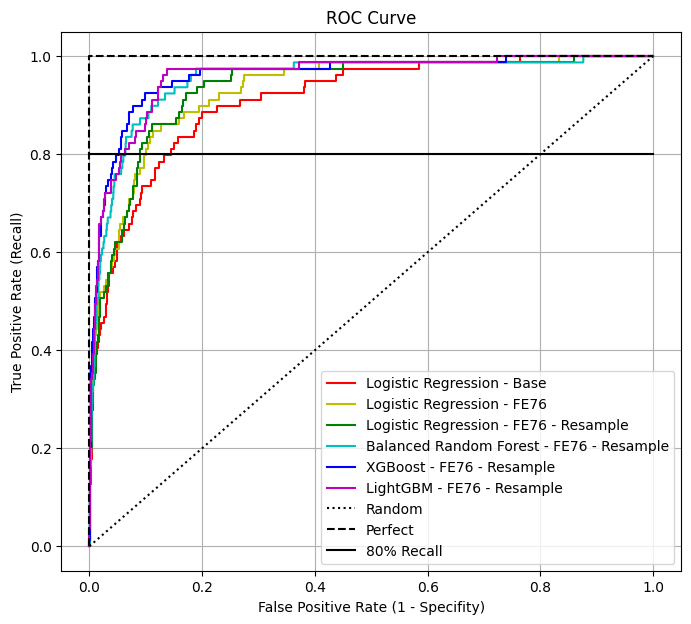

In [117]:
fpr_lr1, tpr_lr1, thr_lr1 = roc_curve(y_test, model_lr_base.predict_proba(Xb_test)[:,1])
fpr_lr2, tpr_lr2, thr_lr2 = roc_curve(y_test, model_lr_fe76.predict_proba(X1_test)[:,1])
fpr_lr3, tpr_lr3, thr_lr3 = roc_curve(y_test, model_lr_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr4, tpr_lr4, thr_lr4 = roc_curve(y_test, model_rf_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr5, tpr_lr5, thr_lr5 = roc_curve(y_test, model_xgb_fe76_rsmpl.predict_proba(X1_test)[:,1])
fpr_lr6, tpr_lr6, thr_lr6 = roc_curve(y_test, model_lgb_fe76_rsmpl.predict_proba(X1_test)[:,1])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr_lr1, tpr_lr1, 'r-', label = 'Logistic Regression - Base')
plt.plot(fpr_lr2, tpr_lr2, 'y-', label = 'Logistic Regression - FE76')
plt.plot(fpr_lr3, tpr_lr3, 'g-', label = 'Logistic Regression - FE76 - Resample')
plt.plot(fpr_lr4, tpr_lr4, 'c-', label = 'Balanced Random Forest - FE76 - Resample')
plt.plot(fpr_lr5, tpr_lr5, 'b-', label = 'XGBoost - FE76 - Resample')
plt.plot(fpr_lr6, tpr_lr6, 'm-', label = 'LightGBM - FE76 - Resample')

plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.plot([0,1],[0.8,0.8],'k-',label='80% Recall')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()